In [3]:
#Download the dataset from opensig
import urllib.request
urllib.request.urlretrieve('http://opendata.deepsig.io/datasets/2016.10/RML2016.10a.tar.bz2', 'RML2016.10a.tar.bz2')

('RML2016.10a.tar.bz2', <http.client.HTTPMessage at 0x7fc2e4665390>)

In [4]:
#decompress the .bz2 file into .tar file
import sys
import os
import bz2

zipfile = bz2.BZ2File('./RML2016.10a.tar.bz2') # open the file
data = zipfile.read() # get the decompressed data

In [5]:
#write the .tar file
open('./RML2016.10a.tar', 'wb').write(data) # write a uncompressed file

640952320

In [6]:
#extract the .tar file
import tarfile
my_tar = tarfile.open('./RML2016.10a.tar')
my_tar.extractall('./') # specify which folder to extract to
my_tar.close()

In [8]:
#extract the pickle file
import pickle
import numpy as np
Xd = pickle.load(open("RML2016.10a_dict.pkl",'rb'),encoding="bytes")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [14]:
# Import all the things we need ---
%matplotlib inline
import random
import tensorflow.keras.utils
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras

In [15]:
# Partition the data
#  into training and test sets of the form we can train/test on 
np.random.seed(2020)
n_examples = X.shape[0]
n_train = n_examples // 2
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]

In [35]:
#one-hot encoding the label
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(np.asarray(lbl)[:,0])
print(lb.classes_)
lbl_encoded=lb.transform(np.asarray(lbl)[:,0])
y_train=lbl_encoded[train_idx]
y_test=lbl_encoded[test_idx]

[b'8PSK' b'AM-DSB' b'AM-SSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16'
 b'QAM64' b'QPSK' b'WBFM']


In [19]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


In [25]:
dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(256, 1, 3, activation="relu", name="conv1"))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80, 1, 3, activation="relu", name="conv2"))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( len(classes), name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_8 (ZeroPaddin (None, 1, 6, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 2, 256)         33024     
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 2, 256)         0         
_________________________________________________________________
zero_padding2d_9 (ZeroPaddin (None, 1, 6, 256)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 2, 80)          20560     
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 2, 80)         

In [26]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

In [30]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
import time
t_0=time.time()
history = model.fit(X_train,
    y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, y_test),
    callbacks = [
        tensorflow.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
delta_t=time.time()-t_0
print(delta_t)
# we re-load the best weights once training is finished
model.load_weights(filepath)

Train on 110000 samples, validate on 110000 samples
Epoch 1/100
110000/110000 - 15s - loss: 2.2894 - val_loss: 2.2247
Epoch 2/100
110000/110000 - 13s - loss: 2.2004 - val_loss: 2.0988
Epoch 3/100
110000/110000 - 13s - loss: 2.0397 - val_loss: 1.9446
Epoch 4/100
110000/110000 - 13s - loss: 1.9606 - val_loss: 1.8768
Epoch 5/100
110000/110000 - 13s - loss: 1.9094 - val_loss: 1.8274
Epoch 6/100
110000/110000 - 13s - loss: 1.8782 - val_loss: 1.8045
Epoch 7/100
110000/110000 - 13s - loss: 1.8631 - val_loss: 1.7910
Epoch 8/100
110000/110000 - 14s - loss: 1.8491 - val_loss: 1.7798
Epoch 9/100
110000/110000 - 13s - loss: 1.8401 - val_loss: 1.7711
Epoch 10/100
110000/110000 - 13s - loss: 1.8300 - val_loss: 1.7640
Epoch 11/100
110000/110000 - 13s - loss: 1.8227 - val_loss: 1.7630
Epoch 12/100
110000/110000 - 13s - loss: 1.8159 - val_loss: 1.7589
Epoch 13/100
110000/110000 - 13s - loss: 1.8115 - val_loss: 1.7460
Epoch 14/100
110000/110000 - 13s - loss: 1.8047 - val_loss: 1.7507
Epoch 15/100
110000

In [31]:
# Show simple version of performance
score = model.evaluate(X_test, y_test, verbose=0, batch_size=batch_size)
print(score)

1.6946204013304278


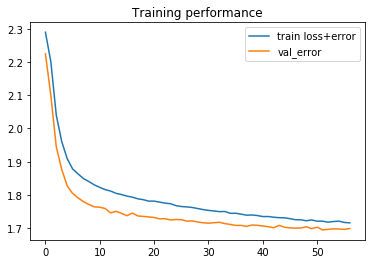

In [32]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [33]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

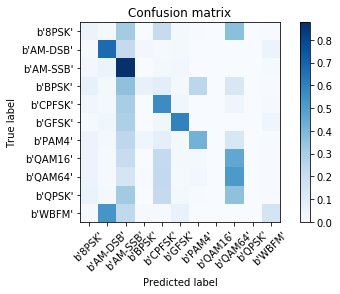

In [34]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)